In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import math
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import preprocessing
import wheat_mlr as wht
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression, PLSSVD

In [53]:
def pcaMLR(df_spectres, df_containment):
    MSE, R2_value = {}, {}
    x_train, x_test = df_spectres.iloc[0:len(df_spectres):2, :], df_spectres.iloc[1:len(df_spectres):2, :]
    train_test_dict = {
        'Влага': wht.getTrainData(df_containment, 'Влага'),
        'Клейковина': wht.getTrainData(df_containment, 'Клейковина'),
        'Зольность': wht.getTrainData(df_containment, 'Зольность')
    }
    pca_lr = PCA()
    reduce_train, reduce_test = pca_lr.fit_transform(preprocessing.scale(x_train)), pca_lr.fit_transform(preprocessing.scale(x_test))
    variance_explained = np.cumsum(np.round(pca_lr.explained_variance_ratio_, decimals=4)*100)
    print(variance_explained)
    for key, value in train_test_dict.items():
        regression = LinearRegression()
        regression.fit(x_train, value[0])
        predicted_results = regression.predict(x_test)
        MSE[key] = mean_squared_error(value[1], predicted_results)
        R2_value[key] = r2_score(value[1], predicted_results)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111)
        axis_x = range(1,8)
        ax.scatter(axis_x, predicted_results, color='red', label='Спрогнозированные данные')
        ax.scatter(axis_x, value[1], color='blue', label='Актуальные данные')
        plt.legend(loc='upper left')
        plt.xticks([i for i in axis_x])
        plt.xlabel('Номер измерения')
        plt.ylabel('Содержание' + key)
        plt.show()
        print('MSE', MSE)
        print('R2_value', R2_value)
#     pca_lr_2 = PCA()
#     reduced_train_test = pca_lr_2.fit_transform(preprocessing.scale(df_spectres))
#     reg = LinearRegression()
#     print(df_containment['Влага'].shape)
#     reg.fit(reduced_train_test, df_containment['Влага'])
#     y_predict = reg.predict(reduced_train_test)
#     R2_value = r2_score(df_containment['Влага'], y_predict)
#     print(R2_value)

In [54]:
def accomplishPCR(df_spectres, df_containment):
    data_spec_containment = pd.concat([df_spectres, df_containment], axis=1, join='inner')
    pca = PCA()
    data_scaled = pca.fit_transform(preprocessing.scale(data_spec_containment))
    variance_explained = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#     print(variance_explained)
    epochs = len(data_scaled)
#     print('epochs', epochs)
    crossval = model_selection.KFold(n_splits=10, shuffle=True, random_state=2)
    regression = LinearRegression()
    mse = []
    for i in np.arange(1,6):
        score = -1*model_selection.cross_val_score(regression, data_scaled[:,:i], df_containment, cv=crossval, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    ax1.plot(mse, '-v')
    ax2.plot([1,2,3,4,5], mse[0:6], '-v')
    ax2.set_title('Intercept excluded from plot')
    for ax in fig.axes:
        ax.set_xlabel('Number of principal components in regression')
        ax.set_ylabel('MSE')
#         ax.set_xlim((-0.2,5.2)) 
    return data_spec_containment

In [64]:
def accomplishPLS(df_spectres, df_containment):
    MSE, R2_value = {}, {}
    x_train, x_test = df_spectres.iloc[0:len(df_spectres):2, :], df_spectres.iloc[1:len(df_spectres):2, :]
    train_test_dict = {
        'Влага': wht.getTrainData(df_containment, 'Влага'),
        'Клейковина': wht.getTrainData(df_containment, 'Клейковина'),
        'Зольность': wht.getTrainData(df_containment, 'Зольность')
    }
    for key, value in train_test_dict.items():
        pls = PLSRegression(n_components=2)
        pls.fit(preprocessing.scale(x_train), value[0])
        MSE[key] = mean_squared_error(value[1], pls.predict(preprocessing.scale(x_test)))
        R2_value[key] = r2_score(value[1],  pls.predict(preprocessing.scale(x_test)))
    print(MSE, R2_value)

In [65]:
def main():
    cwd = os.getcwd()
    cwd_wheat = "C:/Users/Alexander/Desktop/диплом"
    os.chdir(cwd_wheat)
    file_name_df = "Ставр_данные.xlsx"
    df_spectres, df_containment = wht.createDataframes(file_name_df)
    accomplishPCR(df_spectres, df_containment)
    pcaMLR(df_spectres, df_containment)
    accomplishPLS(df_spectres, df_containment)
#     print(df_spectres, '\n', df_containment)

[[0.37099838 0.37768234 0.38007229 ... 0.78701382 0.86518563 0.9625735 ]
 [0.31318505 0.31957383 0.32184596 ... 0.69637202 0.76802097 0.85667287]
 [0.36171046 0.36855623 0.37110044 ... 0.7780644  0.85604888 0.95428594]
 ...
 [0.38048928 0.38753404 0.39008559 ... 0.80134291 0.88074411 0.97922451]
 [0.37345434 0.38007229 0.38247547 ... 0.79263496 0.86966623 0.96497072]
 [0.39555793 0.40263395 0.40527605 ... 0.82073554 0.90031936 0.99913228]]
[99.93 99.98 99.99 99.99 99.99 99.99 99.99]


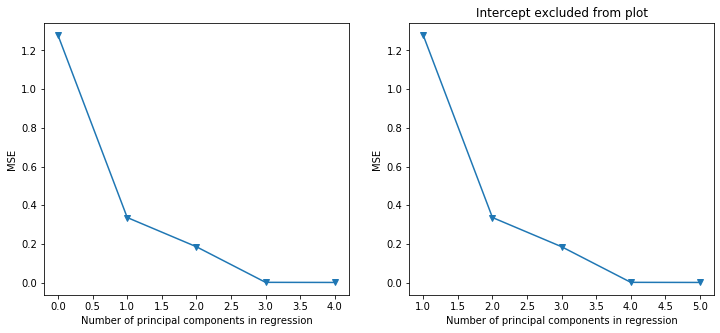

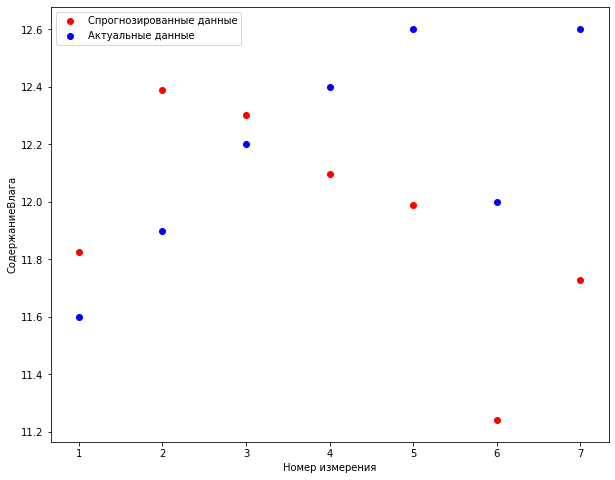

MSE {'Влага': 0.3001224919799798}
R2_value {'Влага': -1.4757579304745816}


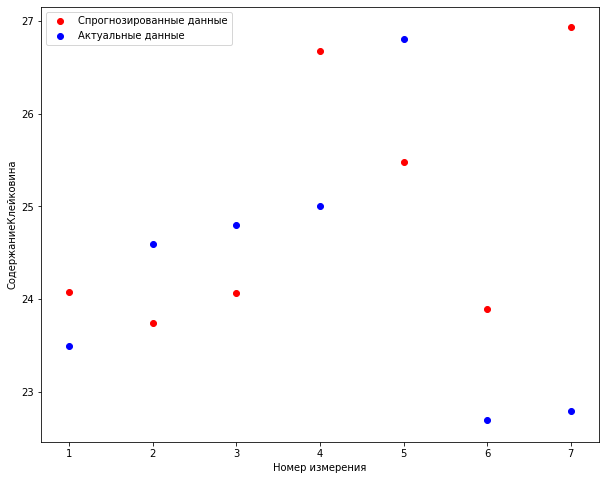

MSE {'Влага': 0.3001224919799798, 'Клейковина': 3.5184438967788703}
R2_value {'Влага': -1.4757579304745816, 'Клейковина': -0.9658352444944653}


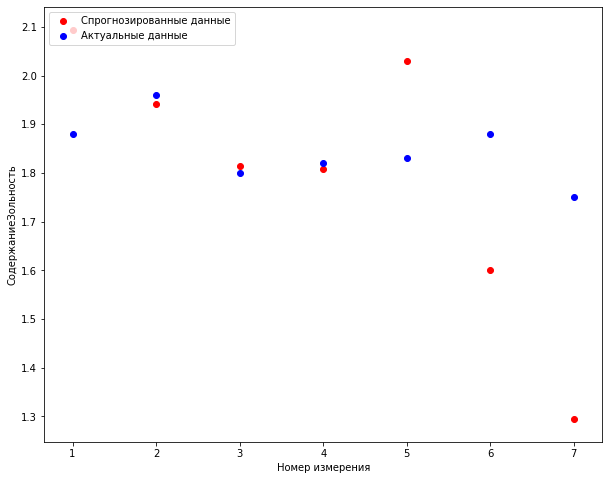

MSE {'Влага': 0.3001224919799798, 'Клейковина': 3.5184438967788703, 'Зольность': 0.05296509477248147}
R2_value {'Влага': -1.4757579304745816, 'Клейковина': -0.9658352444944653, 'Зольность': -12.447096600267333}
{'Влага': 0.74709054120004, 'Клейковина': 5.494809137445563, 'Зольность': 0.0041231085402691926} {'Влага': -5.162868100808413, 'Клейковина': -2.0700758008532785, 'Зольность': -0.046799577581298824}


In [66]:
if __name__ == "__main__":
    main()